=== DISHPATCH SUPPER CLUB - ANALYSE COMMERCIALE COMPLÈTE (CORRIGÉE) ===
📊 Données brutes chargées : 20,443 lignes, 34 colonnes

--- 1. PRÉTRAITEMENT DES DONNÉES ---
📅 Date de référence pour l'analyse : 2025-05-26
Nombre d'inscriptions régulières pour l'analyse : 19,196

--- 2. DÉFINITION DES INDICATEURS CLÉS (LOGIQUE CORRIGÉE) ---

--- 3. AGRÉGATION AU NIVEAU CLIENT UNIQUE ---
⚠️  CORRECTION : Regroupement par Customer Name au lieu de customer_id
Nombre d'enregistrements avant regroupement : 19,196
Nombre de customer_id uniques : 18,738
Nombre de Customer Name uniques : 16,881
Nombre de clients après regroupement correct : 16,881

📊 Clients avec multiples abonnements détectés : 1861
   Exemple - Customer5019 : 31 abonnements
   Total d'abonnements multiples : 2315

--- 4. CALCUL DES KPIS GLOBAUX (CORRIGÉ) ---
Nombre total d'inscrits uniques (non-cadeau) : 16,881
Nombre total de conversions initiales uniques : 7,864
Membres actifs actuellement (payants) : 5,496
Taux de conversion initia

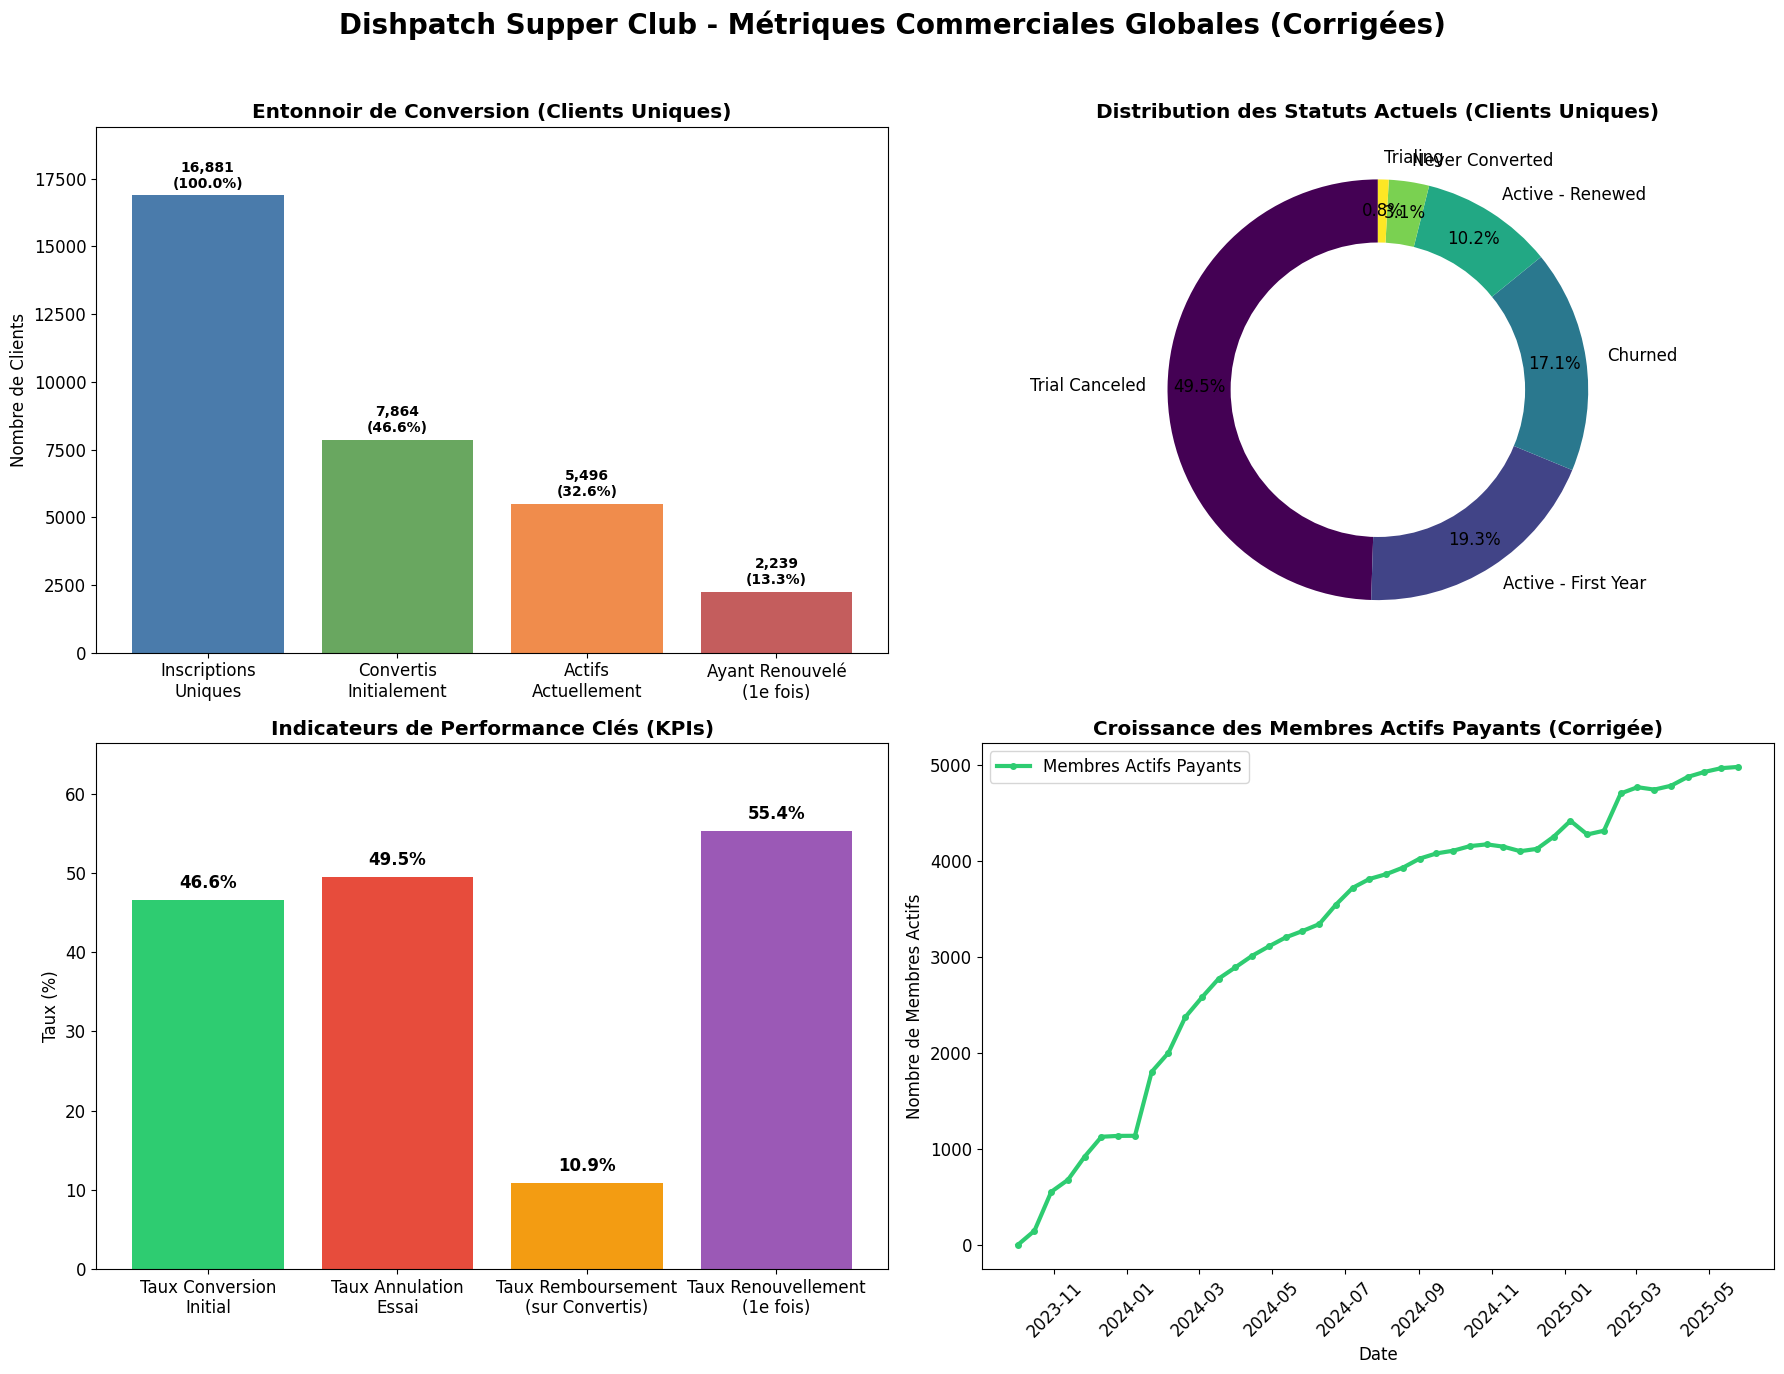


📊 Génération du tableau de bord des cohortes...


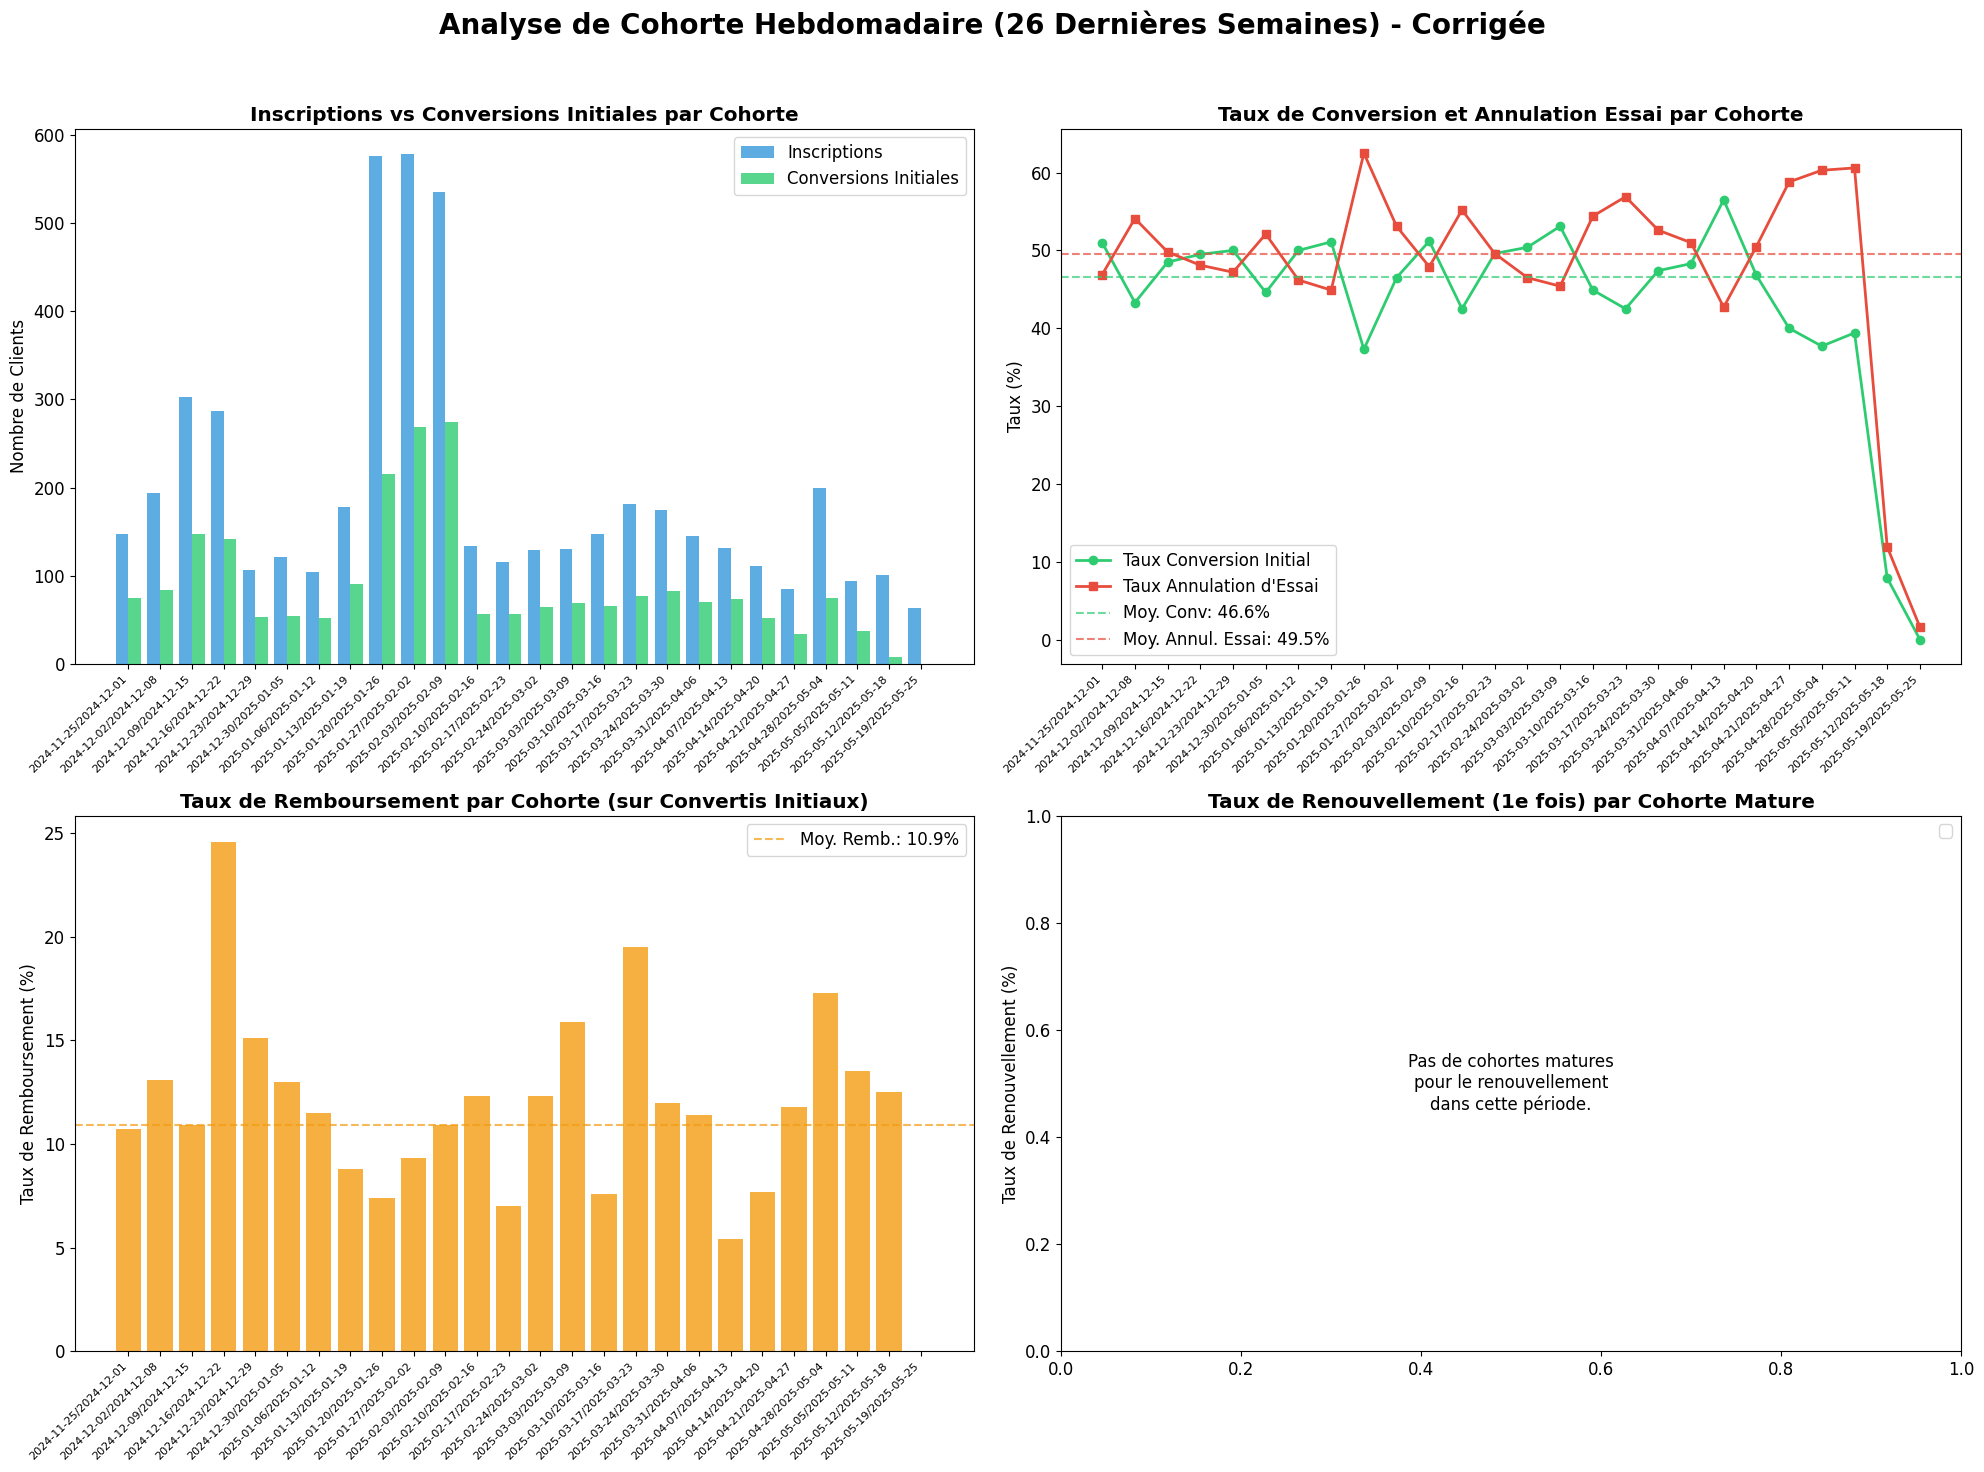


📊 Génération de l'analyse temporelle détaillée...


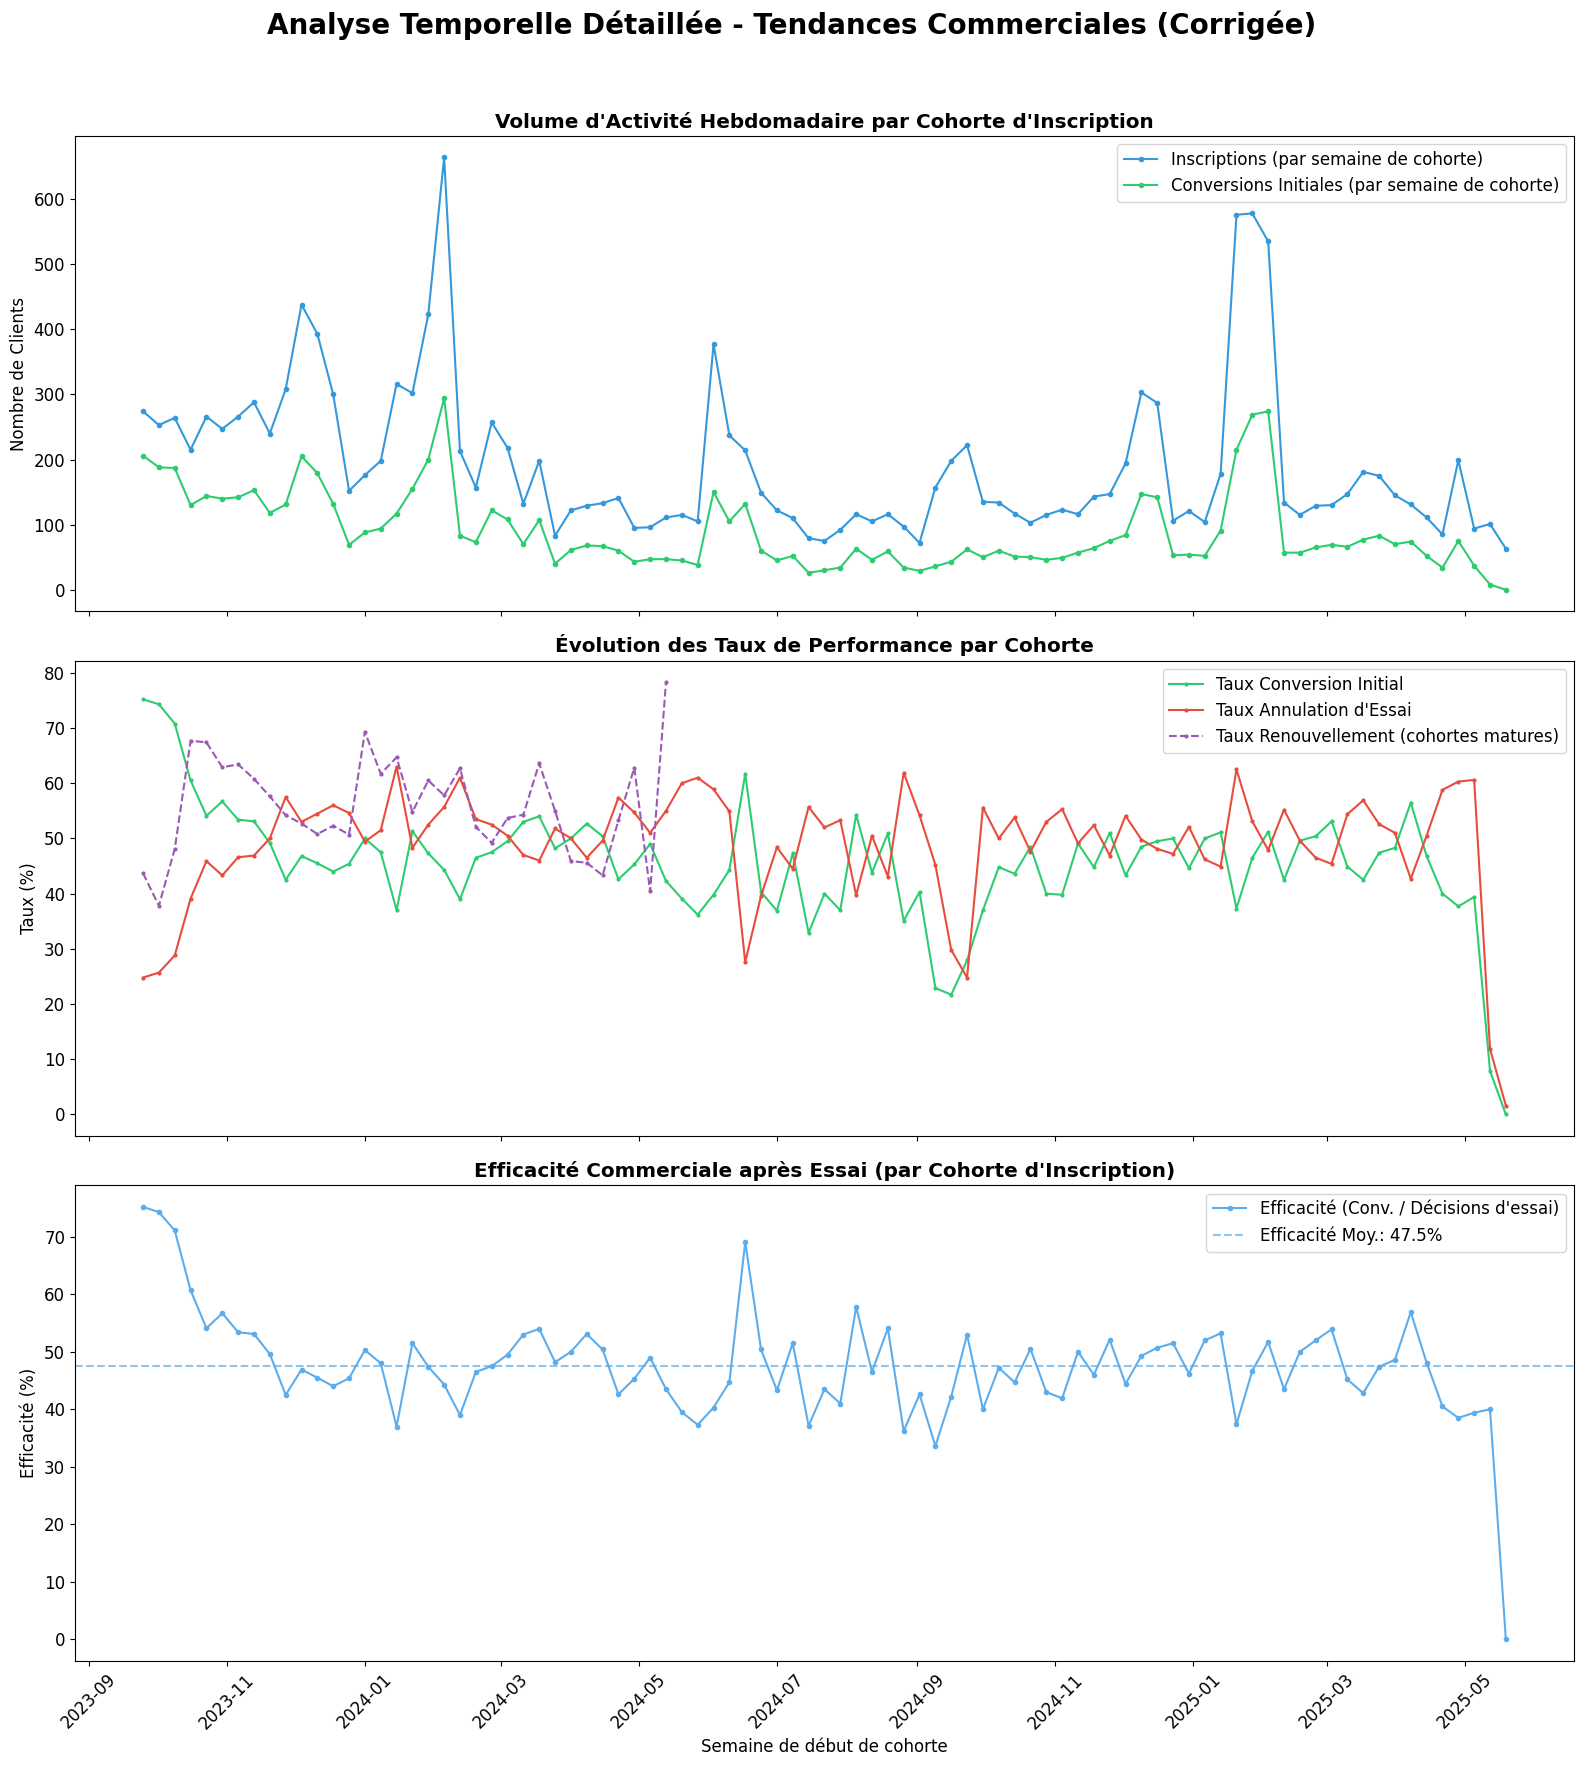


📊 Génération du tableau de bord exécutif...


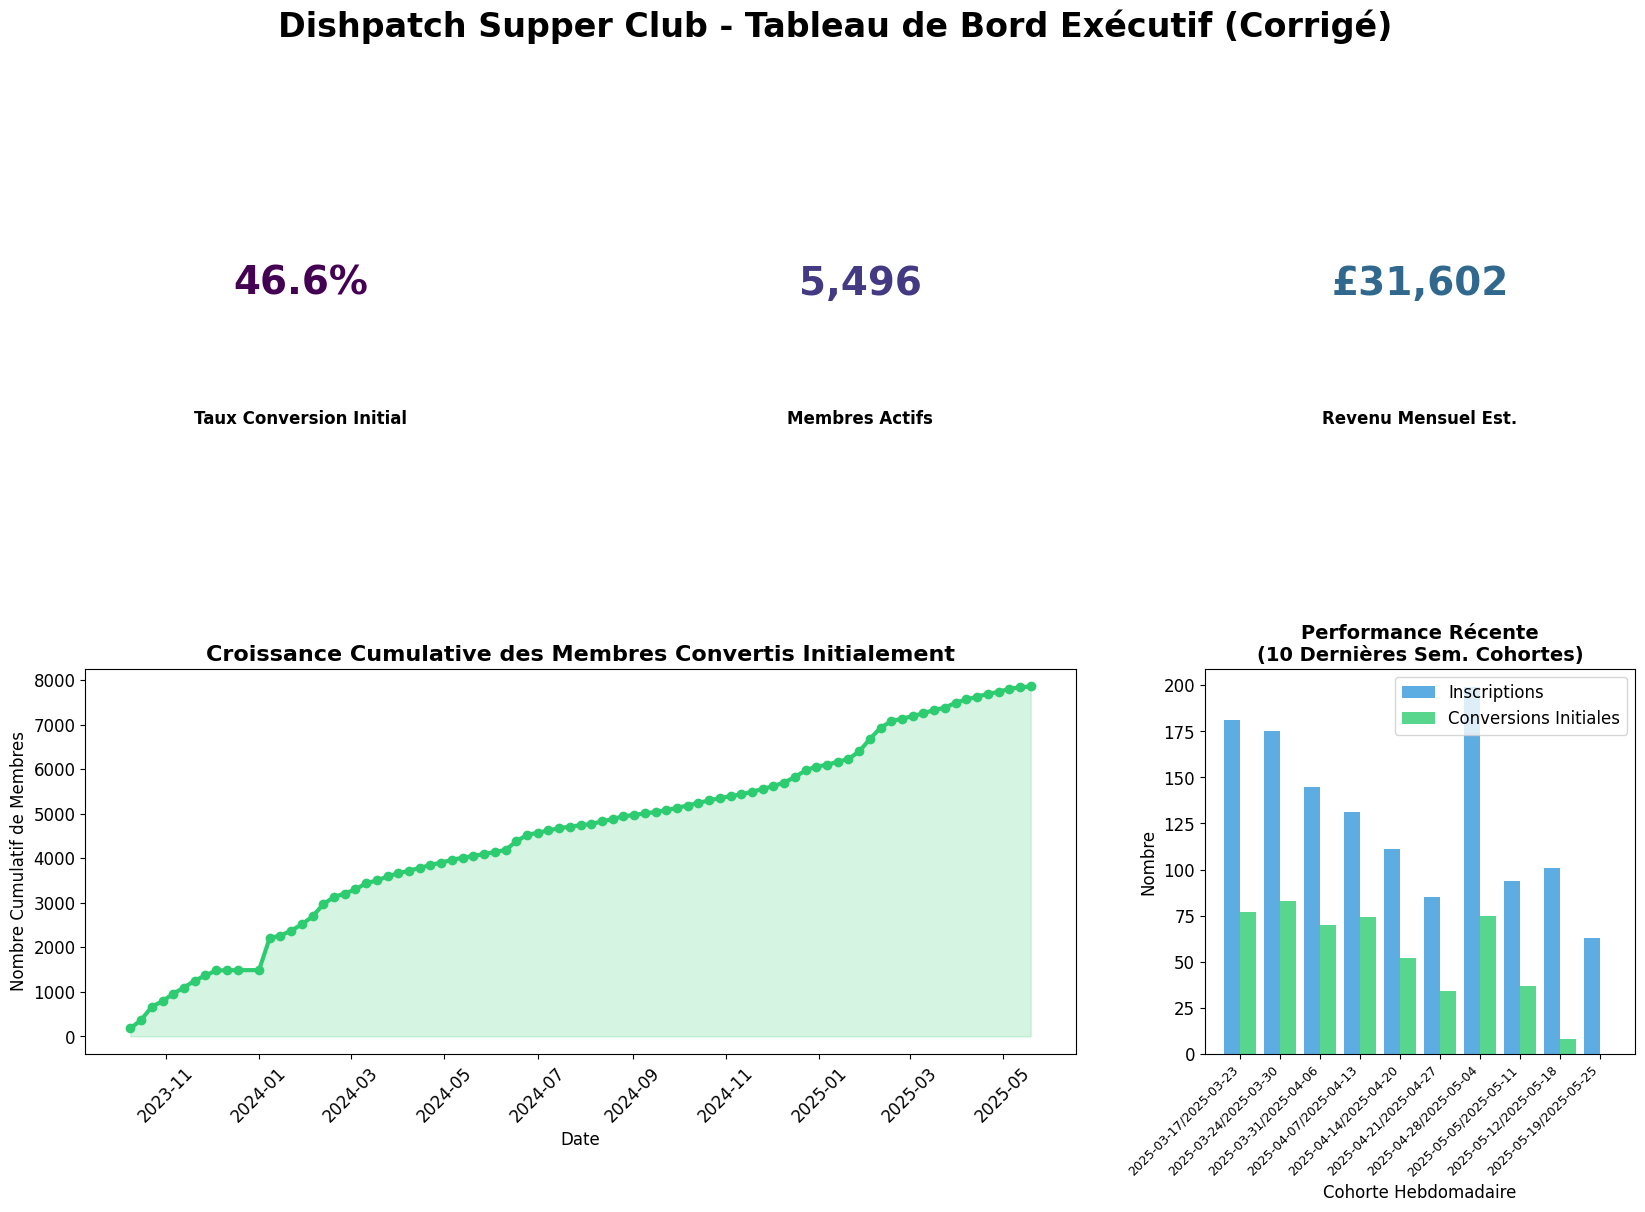


📊 Génération de l'analyse du cycle de vie des clients...


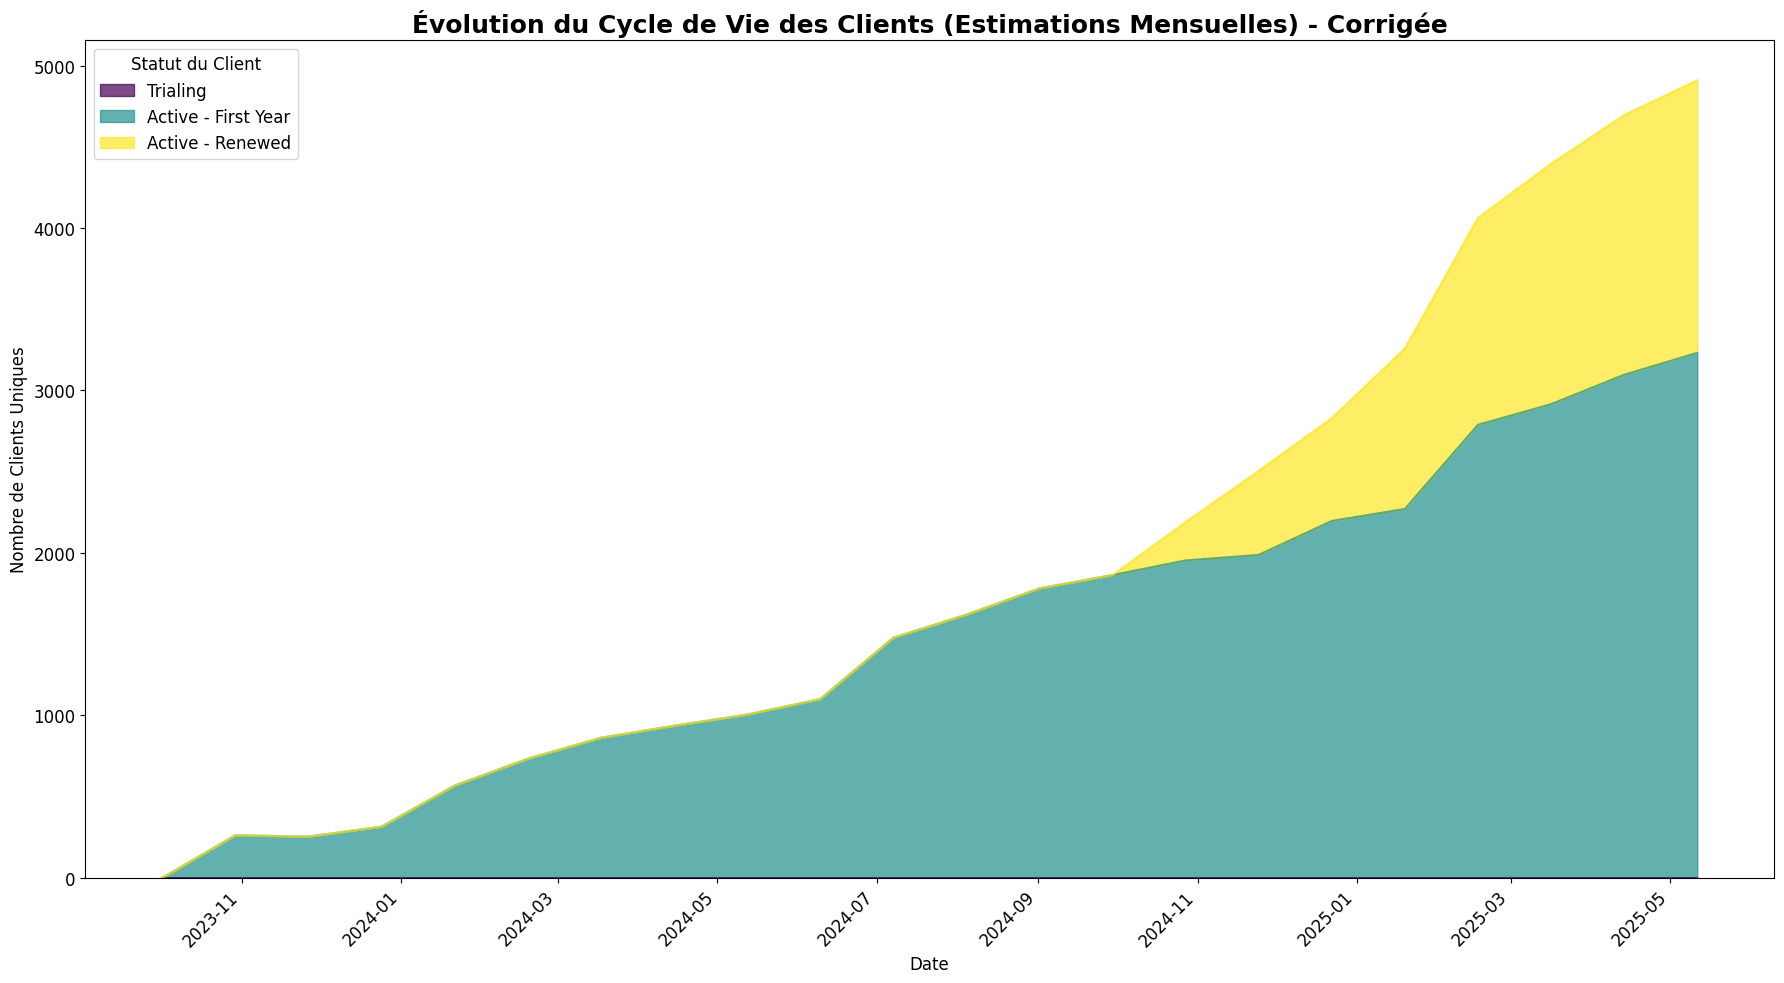


--- 12. RÉSUMÉ DES INDICATEURS CLÉS POUR PRÉSENTATION ---
                                             Indicateur  Valeur
              Inscriptions Uniques Totales (non-cadeau)  16,881
                            Membres Actifs Actuellement   5,496
                             Taux de Conversion Initial   46.6%
        Taux de Renouvellement (1e fois, sur éligibles)   55.4%
                              Taux d'Annulation d'Essai   49.5%
         Taux de Remboursement (sur convertis initiaux)   10.9%
                Revenu Mensuel Estimé (basé sur actifs) £31,602
 Moy. Inscriptions Uniques / Sem. (sur période cohorte)     194
Moy. Conversions Initiales / Sem. (sur période cohorte)      90

🎯 ANALYSE COMPLÈTE ET CORRIGÉE TERMINÉE !

📋 CORRECTIONS APPORTÉES :
1. ✅ Logique de conversion initiale améliorée
2. ✅ Logique de renouvellement plus précise
3. ✅ Calcul des membres actifs basé sur l'historique réel
4. ✅ Gestion robuste des divisions par zéro
5. ✅ Sélection améliorée de l'abonnemen

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import Week
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration générale - CORRIGÉ
plt.style.use('default')  # Utiliser le style par défaut au lieu de seaborn obsolète
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

# --- CONFIGURATION ET CHARGEMENT DES DONNÉES ---
print("=== DISHPATCH SUPPER CLUB - ANALYSE COMMERCIALE COMPLÈTE (CORRIGÉE) ===")
data_dir = os.path.join('data')
file_path = os.path.abspath(os.path.join(data_dir, 'DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv'))

# Spécifier les dtypes pour éviter les DtypeWarning
dtype_spec = {
    'Customer Name': 'str',
    'shipping_address_province (metadata)': 'str',
    'discount_code (metadata)': 'str',
    'referrer (metadata)': 'str'
}

try:
    df_raw = pd.read_csv(file_path, dtype=dtype_spec)
except Exception as e:
    print(f"Erreur lors de la lecture du CSV : {e}")
    print("Veuillez vérifier le chemin du fichier et les spécifications dtype.")
    exit()

print(f"📊 Données brutes chargées : {len(df_raw):,} lignes, {len(df_raw.columns)} colonnes")

# --- PRÉTRAITEMENT DES DONNÉES ---
print("\n--- 1. PRÉTRAITEMENT DES DONNÉES ---")
df = df_raw.copy()

# Conversion des dates
date_cols = [col for col in df.columns if '(UTC)' in col]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Renommage et sélection
df = df.rename(columns={
    'senderShopifyCustomerId (metadata)': 'gift_sender_id',
    'id': 'subscription_id',
    'Customer ID': 'customer_id',
    'Start Date (UTC)': 'signup_date_utc',
    'Trial End (UTC)': 'trial_end_date_utc',
    'Ended At (UTC)': 'ended_at_date_utc',
    'Canceled At (UTC)': 'canceled_at_date_utc',
    'Current Period End (UTC)': 'current_period_end_date_utc'
})

# Date de référence pour l'analyse
reference_date = pd.to_datetime('2025-05-26')
print(f"📅 Date de référence pour l'analyse : {reference_date.strftime('%Y-%m-%d')}")

# Identification des membres cadeaux vs. inscriptions régulières
df['is_gift_member'] = df['gift_sender_id'].notna()
df['is_regular_signup'] = ~df['is_gift_member']

# Filtrer pour ne garder que les inscriptions régulières
analysis_df = df[df['is_regular_signup']].copy()
print(f"Nombre d'inscriptions régulières pour l'analyse : {len(analysis_df):,}")

# --- 2. DÉFINITION DES INDICATEURS CLÉS (LOGIQUE CORRIGÉE) ---
print("\n--- 2. DÉFINITION DES INDICATEURS CLÉS (LOGIQUE CORRIGÉE) ---")

# A. Conversion initiale - CORRIGÉ : Amélioration de la logique
analysis_df['paid_after_trial'] = (
    analysis_df['trial_end_date_utc'].notna() &  # Doit avoir une date de fin d'essai
    (
        # Cas 1: Client toujours actif (n'a jamais été annulé)
        (analysis_df['Status'].isin(['active', 'past_due']) & analysis_df['canceled_at_date_utc'].isna()) |
        # Cas 2: Client annulé APRÈS la fin de l'essai (donc a payé au moins une fois)
        (
            (analysis_df['Status'] == 'canceled') &
            (analysis_df['canceled_at_date_utc'].notna()) &
            (analysis_df['canceled_at_date_utc'] > analysis_df['trial_end_date_utc'])
        )
    )
)

# B. Annulation pendant l'essai - Logique conservée (correcte)
analysis_df['is_trial_cancellation'] = (
    (
        (analysis_df['Status'] == 'canceled') &
        (analysis_df['trial_end_date_utc'].notna()) &
        (analysis_df['canceled_at_date_utc'].notna()) &
        (analysis_df['canceled_at_date_utc'] <= analysis_df['trial_end_date_utc'])
    ) |
    (
        (analysis_df['Status'] == 'canceled') &
        (analysis_df['trial_end_date_utc'].isna()) &
        (analysis_df['canceled_at_date_utc'].notna())
    )
)

# C. Churn post-paiement
analysis_df['is_post_initial_payment_churn'] = (
    analysis_df['paid_after_trial'] & 
    (analysis_df['Status'] == 'canceled')
)

# D. Remboursement - CORRIGÉ : Logique plus robuste
analysis_df['is_refund'] = (
    analysis_df['paid_after_trial'] & 
    (analysis_df['Status'] == 'canceled') & 
    (analysis_df['canceled_at_date_utc'].notna()) &
    (analysis_df['trial_end_date_utc'].notna()) &
    ((analysis_df['canceled_at_date_utc'] - analysis_df['trial_end_date_utc']).dt.days <= 14) &
    ((analysis_df['canceled_at_date_utc'] - analysis_df['trial_end_date_utc']).dt.days >= 0)  # Éviter les valeurs négatives
)

# E. Toujours en essai
analysis_df['is_currently_trialing'] = analysis_df['Status'] == 'trialing'

# F. Date de début de l'abonnement payant
analysis_df['subscription_start_date'] = analysis_df['trial_end_date_utc']

# --- AGRÉGATION AU NIVEAU CLIENT UNIQUE (LOGIQUE CORRIGÉE) ---
print("\n--- 3. AGRÉGATION AU NIVEAU CLIENT UNIQUE ---")

# CORRECTION MAJEURE : Regrouper par Customer Name au lieu de customer_id
# Car un même client peut avoir plusieurs customer_id (réabonnements)
print("⚠️  CORRECTION : Regroupement par Customer Name au lieu de customer_id")

def get_representative_subscription(group):
    """
    Pour un client donné (Customer Name), sélectionne l'abonnement le plus représentatif
    Priorité : 1) Premier abonnement converti, 2) Premier chronologiquement
    """
    group_sorted = group.sort_values('signup_date_utc')
    
    # D'abord, essayer de prendre la première inscription qui a converti
    converted_subs = group_sorted[group_sorted['paid_after_trial']]
    if not converted_subs.empty:
        return converted_subs.iloc[0]
    
    # Sinon, prendre la première inscription chronologiquement
    return group_sorted.iloc[0]

# REGROUPEMENT CORRIGÉ par Customer Name
customer_df = analysis_df.groupby('Customer Name').apply(get_representative_subscription).reset_index(drop=True)

# Vérification du nombre de clients uniques avant/après
print(f"Nombre d'enregistrements avant regroupement : {len(analysis_df):,}")
print(f"Nombre de customer_id uniques : {analysis_df['customer_id'].nunique():,}")
print(f"Nombre de Customer Name uniques : {analysis_df['Customer Name'].nunique():,}")
print(f"Nombre de clients après regroupement correct : {len(customer_df):,}")

# Exemple de clients avec multiples abonnements
multi_sub_customers = analysis_df.groupby('Customer Name').size()
multi_sub_customers = multi_sub_customers[multi_sub_customers > 1].sort_values(ascending=False)
if len(multi_sub_customers) > 0:
    print(f"\n📊 Clients avec multiples abonnements détectés : {len(multi_sub_customers)}")
    print(f"   Exemple - {multi_sub_customers.index[0]} : {multi_sub_customers.iloc[0]} abonnements")
    print(f"   Total d'abonnements multiples : {(multi_sub_customers - 1).sum()}")
else:
    print("\n✅ Aucun client avec multiples abonnements détecté")

# Indicateurs au niveau client
customer_df['paid_initial_subscription'] = customer_df['paid_after_trial']
customer_df['trial_canceled'] = customer_df['is_trial_cancellation']
customer_df['refunded_initial'] = customer_df['is_refund']
customer_df['currently_trialing'] = customer_df['is_currently_trialing']
customer_df['first_subscription_start_date'] = customer_df['subscription_start_date']

# CORRIGÉ : Logique de renouvellement améliorée
customer_df['eligible_for_1st_renewal'] = (
    customer_df['paid_initial_subscription'] & 
    customer_df['first_subscription_start_date'].notna() & 
    ((reference_date - customer_df['first_subscription_start_date']).dt.days >= 365)  # >= au lieu de >
)

customer_df['renewal_due_date_1st'] = customer_df['first_subscription_start_date'] + pd.Timedelta(days=365)

# CORRIGÉ : Logique de renouvellement plus précise
customer_df['actually_renewed_1st'] = (
    customer_df['eligible_for_1st_renewal'] & 
    (
        # Cas 1: Toujours actif et pas d'annulation avant le renouvellement
        (
            customer_df['Status'].isin(['active', 'past_due']) & 
            (customer_df['canceled_at_date_utc'].isna() | 
             (customer_df['canceled_at_date_utc'] > customer_df['renewal_due_date_1st']))
        ) |
        # Cas 2: Annulé mais APRÈS le renouvellement (donc a renouvelé puis annulé)
        (
            (customer_df['Status'] == 'canceled') &
            (customer_df['canceled_at_date_utc'].notna()) &
            (customer_df['canceled_at_date_utc'] > customer_df['renewal_due_date_1st']) &
            (customer_df['ended_at_date_utc'].isna() | 
             (customer_df['ended_at_date_utc'] > customer_df['renewal_due_date_1st']))
        )
    )
)

# CORRIGÉ : Statut actuel du client amélioré
def determine_customer_status(row):
    if row['trial_canceled']:
        return 'Trial Canceled'
    elif row['currently_trialing']:
        return 'Trialing'
    elif not row['paid_initial_subscription']:
        return 'Never Converted'
    elif row['actually_renewed_1st'] and row['Status'] in ['active', 'past_due']:
        return 'Active - Renewed'
    elif row['paid_initial_subscription'] and row['Status'] in ['active', 'past_due']:
        return 'Active - First Year'
    else:
        return 'Churned'

customer_df['current_status_agg'] = customer_df.apply(determine_customer_status, axis=1)

# --- 4. CALCUL DES KPIS GLOBAUX (CORRIGÉ) ---
print("\n--- 4. CALCUL DES KPIS GLOBAUX (CORRIGÉ) ---")

# CORRECTION : Utiliser Customer Name pour les calculs d'unicité
total_unique_signups = customer_df['Customer Name'].nunique()
total_initial_conversions = customer_df['paid_initial_subscription'].sum()
total_trial_cancellations = customer_df['trial_canceled'].sum()
total_refunded = customer_df['refunded_initial'].sum()
total_eligible_for_renewal = customer_df['eligible_for_1st_renewal'].sum()
total_actually_renewed = customer_df['actually_renewed_1st'].sum()

# CORRECTION : Utiliser Customer Name pour compter les membres actifs
current_active_members = customer_df[customer_df['Status'].isin(['active', 'past_due'])]['Customer Name'].nunique()

# CORRIGÉ : Calculs KPI plus robustes
kpi_conversion_rate = (total_initial_conversions / total_unique_signups * 100) if total_unique_signups > 0 else 0
kpi_trial_cancel_rate = (total_trial_cancellations / total_unique_signups * 100) if total_unique_signups > 0 else 0
kpi_refund_rate = (total_refunded / total_initial_conversions * 100) if total_initial_conversions > 0 else 0
kpi_renewal_rate = (total_actually_renewed / total_eligible_for_renewal * 100) if total_eligible_for_renewal > 0 else 0

print(f"Nombre total d'inscrits uniques (non-cadeau) : {total_unique_signups:,}")
print(f"Nombre total de conversions initiales uniques : {total_initial_conversions:,}")
print(f"Membres actifs actuellement (payants) : {current_active_members:,}")
print(f"Taux de conversion initial : {kpi_conversion_rate:.1f}%")
print(f"Taux d'annulation d'essai : {kpi_trial_cancel_rate:.1f}%")
print(f"Taux de remboursement (sur convertis initiaux) : {kpi_refund_rate:.1f}%")
print(f"Clients éligibles au 1er renouvellement : {total_eligible_for_renewal:,}")
print(f"Clients ayant effectivement effectué le 1er renouvellement : {total_actually_renewed:,}")
print(f"Taux de renouvellement (sur éligibles) : {kpi_renewal_rate:.1f}%")

# --- 5. ANALYSE DE COHORTE TEMPORELLE (CORRIGÉE) ---
print("\n--- 5. ANALYSE DE COHORTE TEMPORELLE (CORRIGÉE) ---")
customer_df['signup_week'] = customer_df['signup_date_utc'].dt.to_period('W-SUN')

# CORRECTION : Utiliser Customer Name pour l'unicité dans l'analyse de cohorte
cohort_analysis_df = customer_df.groupby('signup_week').agg(
    total_signups_cohort=('Customer Name', 'nunique'),  # CORRIGÉ
    initial_conversions_cohort=('paid_initial_subscription', 'sum'),
    trial_cancellations_cohort=('trial_canceled', 'sum'),
    refunds_cohort=('refunded_initial', 'sum'),
    eligible_for_renewal_cohort=('eligible_for_1st_renewal', 'sum'),
    actually_renewed_cohort=('actually_renewed_1st', 'sum')
).reset_index()

# CORRIGÉ : Calculs de taux plus robustes
cohort_analysis_df['conversion_rate_cohort'] = np.where(
    cohort_analysis_df['total_signups_cohort'] > 0,
    (cohort_analysis_df['initial_conversions_cohort'] / cohort_analysis_df['total_signups_cohort'] * 100),
    0
).round(1)

cohort_analysis_df['trial_cancel_rate_cohort'] = np.where(
    cohort_analysis_df['total_signups_cohort'] > 0,
    (cohort_analysis_df['trial_cancellations_cohort'] / cohort_analysis_df['total_signups_cohort'] * 100),
    0
).round(1)

cohort_analysis_df['refund_rate_cohort'] = np.where(
    cohort_analysis_df['initial_conversions_cohort'] > 0,
    (cohort_analysis_df['refunds_cohort'] / cohort_analysis_df['initial_conversions_cohort'] * 100),
    0
).round(1)

cohort_analysis_df['renewal_rate_cohort'] = np.where(
    cohort_analysis_df['eligible_for_renewal_cohort'] > 0,
    (cohort_analysis_df['actually_renewed_cohort'] / cohort_analysis_df['eligible_for_renewal_cohort'] * 100),
    0
).round(1)

print(f"Cohortes analysées : {len(cohort_analysis_df)}")
print(cohort_analysis_df.tail())

# --- 6. PRÉPARATION DES DONNÉES POUR VISUALISATIONS TEMPORELLES (CORRIGÉE) ---
print("\n--- 6. PRÉPARATION DES DONNÉES TEMPORELLES ---")

# CORRIGÉ : Croissance des membres actifs basée sur l'historique réel
def calculate_active_members_at_date(target_date):
    """Calcule le nombre de membres actifs à une date donnée basé sur l'historique"""
    active_count = 0
    for _, customer in customer_df.iterrows():
        # Le client doit avoir converti avant cette date
        if (customer['paid_initial_subscription'] and 
            customer['first_subscription_start_date'] <= target_date):
            
            # Vérifier s'il était encore actif à cette date
            still_active = True
            
            # Si annulé, vérifier si c'était avant cette date
            if (customer['canceled_at_date_utc'] and 
                customer['canceled_at_date_utc'] <= target_date):
                still_active = False
            
            # Si date de fin définie, vérifier si c'était avant cette date
            if (customer['ended_at_date_utc'] and 
                customer['ended_at_date_utc'] <= target_date):
                still_active = False
            
            if still_active:
                active_count += 1
    
    return active_count

# Générer la timeline des membres actifs (échantillonné pour la performance)
date_range_for_plots = pd.date_range(
    analysis_df['signup_date_utc'].min(), 
    reference_date, 
    freq='2W'  # Toutes les 2 semaines pour réduire le temps de calcul
)

active_timeline = []
for date in date_range_for_plots:
    active_count = calculate_active_members_at_date(date)
    active_timeline.append({'week_start': date, 'active_members': active_count})

active_members_df = pd.DataFrame(active_timeline)

# Croissance cumulative des conversions initiales - CORRIGÉ
cumulative_conversions_df = customer_df[customer_df['paid_initial_subscription']].groupby(
    customer_df['first_subscription_start_date'].dt.to_period('W-SUN')
)['Customer Name'].nunique().cumsum().reset_index()  # CORRIGÉ : Customer Name au lieu de customer_id
cumulative_conversions_df.columns = ['week', 'cumulative_initial_conversions']
cumulative_conversions_df['week_start'] = cumulative_conversions_df['week'].dt.start_time

print("📊 Données temporelles préparées avec logique corrigée")

# --- 7. FONCTION D'AIDE POUR LES VISUALISATIONS ---
def create_improved_visualizations():
    """Crée les visualisations avec la logique corrigée"""
    
    # VISUALISATION 1: TABLEAU DE BORD GLOBAL
    fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Dishpatch Supper Club - Métriques Commerciales Globales (Corrigées)', 
                  fontsize=20, fontweight='bold')

    # 1.1 Entonnoir de Conversion
    funnel_stages = ['Inscriptions\nUniques', 'Convertis\nInitialement', 'Actifs\nActuellement', 'Ayant Renouvelé\n(1e fois)']
    funnel_counts = [total_unique_signups, total_initial_conversions, current_active_members, total_actually_renewed]
    funnel_colors = ['#4a7bab', '#69a760', '#f08c4c', '#c45d5d']

    bars = ax1.bar(funnel_stages, funnel_counts, color=funnel_colors)
    ax1.set_title('Entonnoir de Conversion (Clients Uniques)', fontweight='bold')
    ax1.set_ylabel('Nombre de Clients')
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        percentage = (height / funnel_counts[0] * 100) if funnel_counts[0] > 0 else 0
        ax1.text(bar.get_x() + bar.get_width()/2., height + (0.01 * max(funnel_counts)), 
                f'{height:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax1.set_ylim(0, max(funnel_counts) * 1.15)

    # 1.2 Distribution des Statuts
    status_counts_agg = customer_df['current_status_agg'].value_counts()
    colors = plt.cm.viridis(np.linspace(0, 1, len(status_counts_agg)))
    
    wedges, texts, autotexts = ax2.pie(status_counts_agg.values, labels=status_counts_agg.index, 
                                       autopct='%1.1f%%', colors=colors, startangle=90, pctdistance=0.85)
    ax2.set_title('Distribution des Statuts Actuels (Clients Uniques)', fontweight='bold')
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax2.add_artist(centre_circle)

    # 1.3 KPIs Commerciaux Clés
    kpi_names = ['Taux Conversion\nInitial', 'Taux Annulation\nEssai', 'Taux Remboursement\n(sur Convertis)', 'Taux Renouvellement\n(1e fois)']
    kpi_values = [kpi_conversion_rate, kpi_trial_cancel_rate, kpi_refund_rate, kpi_renewal_rate]
    kpi_colors = ['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
    
    kpi_bars = ax3.bar(kpi_names, kpi_values, color=kpi_colors)
    ax3.set_title('Indicateurs de Performance Clés (KPIs)', fontweight='bold')
    ax3.set_ylabel('Taux (%)')
    
    for bar in kpi_bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', 
                ha='center', va='bottom', fontweight='bold')
    ax3.set_ylim(0, max(kpi_values) * 1.2 if kpi_values else 10)

    # 1.4 Croissance des Membres Actifs
    ax4.plot(active_members_df['week_start'], active_members_df['active_members'],
             linewidth=3, color='#2ecc71', marker='o', markersize=4, label="Membres Actifs Payants")
    ax4.set_title('Croissance des Membres Actifs Payants (Corrigée)', fontweight='bold')
    ax4.set_ylabel('Nombre de Membres Actifs')
    ax4.set_xlabel('Date')
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax4.tick_params(axis='x', rotation=45)
    ax4.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Lancer les visualisations améliorées
create_improved_visualizations()

# --- 8. VISUALISATION 2: ANALYSE DE COHORTE HEBDOMADAIRE ---
print("\n📊 Génération du tableau de bord des cohortes...")
recent_cohorts = cohort_analysis_df.tail(26).copy()
recent_cohorts['cohort_week_str'] = recent_cohorts['signup_week'].astype(str)

fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
fig2.suptitle('Analyse de Cohorte Hebdomadaire (26 Dernières Semaines) - Corrigée', fontsize=20, fontweight='bold')
x_pos_cohort = np.arange(len(recent_cohorts))

# 2.1 Inscriptions vs Conversions Initiales par Semaine
ax1.bar(x_pos_cohort - 0.2, recent_cohorts['total_signups_cohort'], width=0.4, label='Inscriptions', color='#3498db', alpha=0.8)
ax1.bar(x_pos_cohort + 0.2, recent_cohorts['initial_conversions_cohort'], width=0.4, label='Conversions Initiales', color='#2ecc71', alpha=0.8)
ax1.set_title('Inscriptions vs Conversions Initiales par Cohorte', fontweight='bold')
ax1.set_ylabel('Nombre de Clients')
ax1.set_xticks(x_pos_cohort)
ax1.set_xticklabels(recent_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)
ax1.legend()

# 2.2 Taux de Conversion et d'Annulation d'Essai par Cohorte
ax2.plot(x_pos_cohort, recent_cohorts['conversion_rate_cohort'], linewidth=2, color='#2ecc71', marker='o', label='Taux Conversion Initial')
ax2.plot(x_pos_cohort, recent_cohorts['trial_cancel_rate_cohort'], linewidth=2, color='#e74c3c', marker='s', label="Taux Annulation d'Essai")
ax2.set_title('Taux de Conversion et Annulation Essai par Cohorte', fontweight='bold')
ax2.set_ylabel('Taux (%)')
ax2.set_xticks(x_pos_cohort)
ax2.set_xticklabels(recent_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)
ax2.axhline(y=kpi_conversion_rate, color='#2ecc71', linestyle='--', alpha=0.7, label=f'Moy. Conv: {kpi_conversion_rate:.1f}%')
ax2.axhline(y=kpi_trial_cancel_rate, color='#e74c3c', linestyle='--', alpha=0.7, label=f'Moy. Annul. Essai: {kpi_trial_cancel_rate:.1f}%')
ax2.legend()

# 2.3 Taux de Remboursement par Cohorte
ax3.bar(x_pos_cohort, recent_cohorts['refund_rate_cohort'], color='#f39c12', alpha=0.8)
ax3.set_title('Taux de Remboursement par Cohorte (sur Convertis Initiaux)', fontweight='bold')
ax3.set_ylabel('Taux de Remboursement (%)')
ax3.set_xticks(x_pos_cohort)
ax3.set_xticklabels(recent_cohorts['cohort_week_str'], rotation=45, ha="right", fontsize=8)
ax3.axhline(y=kpi_refund_rate, color='#f39c12', linestyle='--', alpha=0.7, label=f'Moy. Remb.: {kpi_refund_rate:.1f}%')
ax3.legend()

# 2.4 Taux de Renouvellement par Cohorte (pour les cohortes matures)
mature_cohorts_for_renewal = recent_cohorts[recent_cohorts['eligible_for_renewal_cohort'] > 0]
if not mature_cohorts_for_renewal.empty:
    x_pos_renewal_cohort = np.arange(len(mature_cohorts_for_renewal))
    ax4.bar(x_pos_renewal_cohort, mature_cohorts_for_renewal['renewal_rate_cohort'], color='#9b59b6', alpha=0.8)
    ax4.set_xticks(x_pos_renewal_cohort)
    ax4.set_xticklabels(mature_cohorts_for_renewal['cohort_week_str'], rotation=45, ha="right", fontsize=8)
    ax4.axhline(y=kpi_renewal_rate, color='#9b59b6', linestyle='--', alpha=0.7, label=f'Moy. Renouv.: {kpi_renewal_rate:.1f}%')
else:
    ax4.text(0.5, 0.5, "Pas de cohortes matures\npour le renouvellement\ndans cette période.", 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)

ax4.set_title('Taux de Renouvellement (1e fois) par Cohorte Mature', fontweight='bold')
ax4.set_ylabel('Taux de Renouvellement (%)')
ax4.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 9. VISUALISATION 3: ANALYSE TEMPORELLE DÉTAILLÉE ---
print("\n📊 Génération de l'analyse temporelle détaillée...")
all_cohorts_df = cohort_analysis_df.copy()
all_cohorts_df['cohort_week_dt'] = all_cohorts_df['signup_week'].dt.start_time

fig3, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 18), sharex=True)
fig3.suptitle('Analyse Temporelle Détaillée - Tendances Commerciales (Corrigée)', fontsize=20, fontweight='bold')

# 3.1 Volume d'Activité Hebdomadaire
ax1.plot(all_cohorts_df['cohort_week_dt'], all_cohorts_df['total_signups_cohort'], 
         label='Inscriptions (par semaine de cohorte)', color='#3498db', marker='.', linestyle='-')
ax1.plot(all_cohorts_df['cohort_week_dt'], all_cohorts_df['initial_conversions_cohort'], 
         label='Conversions Initiales (par semaine de cohorte)', color='#2ecc71', marker='.', linestyle='-')
ax1.set_title("Volume d'Activité Hebdomadaire par Cohorte d'Inscription", fontweight='bold')
ax1.set_ylabel('Nombre de Clients')
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 3.2 Évolution des Taux de Performance
ax2.plot(all_cohorts_df['cohort_week_dt'], all_cohorts_df['conversion_rate_cohort'], 
         label='Taux Conversion Initial', color='#2ecc71', marker='.', markersize=4)
ax2.plot(all_cohorts_df['cohort_week_dt'], all_cohorts_df['trial_cancel_rate_cohort'], 
         label="Taux Annulation d'Essai", color='#e74c3c', marker='.', markersize=4)

mature_renewal_trend = all_cohorts_df[all_cohorts_df['eligible_for_renewal_cohort'] > 5]
if not mature_renewal_trend.empty:
    ax2.plot(mature_renewal_trend['cohort_week_dt'], mature_renewal_trend['renewal_rate_cohort'], 
             label='Taux Renouvellement (cohortes matures)', color='#9b59b6', marker='.', markersize=4, linestyle='--')

ax2.set_title('Évolution des Taux de Performance par Cohorte', fontweight='bold')
ax2.set_ylabel('Taux (%)')
ax2.legend()

# 3.3 Efficacité Commerciale
all_cohorts_df['total_decisions_cohort'] = all_cohorts_df['initial_conversions_cohort'] + all_cohorts_df['trial_cancellations_cohort']
all_cohorts_df['efficiency_rate_cohort'] = np.where(
    all_cohorts_df['total_decisions_cohort'] > 0,
    (all_cohorts_df['initial_conversions_cohort'] / all_cohorts_df['total_decisions_cohort'] * 100),
    0
).round(1)

valid_efficiency = all_cohorts_df[all_cohorts_df['total_decisions_cohort'] > 0]['efficiency_rate_cohort']
avg_efficiency = valid_efficiency.mean() if len(valid_efficiency) > 0 else 0

ax3.plot(all_cohorts_df['cohort_week_dt'], all_cohorts_df['efficiency_rate_cohort'], 
         label="Efficacité (Conv. / Décisions d'essai)", color='#5dadec', marker='.', linestyle='-')
ax3.axhline(y=avg_efficiency, color='#5dadec', linestyle='--', alpha=0.7, label=f'Efficacité Moy.: {avg_efficiency:.1f}%')
ax3.set_title("Efficacité Commerciale après Essai (par Cohorte d'Inscription)", fontweight='bold')
ax3.set_ylabel('Efficacité (%)')
ax3.set_xlabel('Semaine de début de cohorte')
ax3.legend()
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 10. VISUALISATION 4: TABLEAU DE BORD EXÉCUTIF ---
print("\n📊 Génération du tableau de bord exécutif...")
fig4 = plt.figure(figsize=(20, 12))
gs = fig4.add_gridspec(2, 3, hspace=0.4, wspace=0.3)
fig4.suptitle('Dishpatch Supper Club - Tableau de Bord Exécutif (Corrigé)', fontsize=24, fontweight='bold', y=0.98)

# KPIs Textuels en haut
kpi_data_exec = [
    ("Taux Conversion Initial", f"{kpi_conversion_rate:.1f}%"),
    ("Membres Actifs", f"{current_active_members:,}"),
    ("Revenu Mensuel Est.", f"£{current_active_members * 69 / 12:,.0f}"),
    ("Taux Remboursement", f"{kpi_refund_rate:.1f}%"),
    ("Taux Renouvellement", f"{kpi_renewal_rate:.1f}%"),
    ("Inscriptions Uniques", f"{total_unique_signups:,}")
]

for i in range(min(6, len(kpi_data_exec))):
    row = i // 3
    col = i % 3
    ax_kpi = fig4.add_subplot(gs[0, col]) if row == 0 else fig4.add_subplot(gs[1, col])
    
    title, value = kpi_data_exec[i]
    color = plt.cm.viridis(i / len(kpi_data_exec))
    
    ax_kpi.text(0.5, 0.6, value, ha='center', va='center', fontsize=28, fontweight='bold', color=color)
    ax_kpi.text(0.5, 0.25, title, ha='center', va='center', fontsize=12, fontweight='bold')
    ax_kpi.axis('off')

# Réajuster pour les graphiques en bas
fig4.delaxes(fig4.add_subplot(gs[1, 0]))
fig4.delaxes(fig4.add_subplot(gs[1, 1]))
fig4.delaxes(fig4.add_subplot(gs[1, 2]))

# Graphique Principal: Croissance Cumulative
ax_main = fig4.add_subplot(gs[1, :2])
if not cumulative_conversions_df.empty:
    ax_main.plot(cumulative_conversions_df['week_start'], cumulative_conversions_df['cumulative_initial_conversions'], 
                linewidth=3, color='#2ecc71', marker='o', markersize=6)
    ax_main.fill_between(cumulative_conversions_df['week_start'], cumulative_conversions_df['cumulative_initial_conversions'], 
                        alpha=0.2, color='#2ecc71')
ax_main.set_title('Croissance Cumulative des Membres Convertis Initialement', fontsize=16, fontweight='bold')
ax_main.set_ylabel('Nombre Cumulatif de Membres')
ax_main.set_xlabel('Date')
ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax_main.tick_params(axis='x', rotation=45)

# Graphique Secondaire: Performance Récente
ax_perf = fig4.add_subplot(gs[1, 2])
recent_10_cohorts = cohort_analysis_df.tail(10).copy()
if not recent_10_cohorts.empty:
    x_pos_recent = np.arange(len(recent_10_cohorts))
    ax_perf.bar(x_pos_recent - 0.2, recent_10_cohorts['total_signups_cohort'], width=0.4, 
               label='Inscriptions', color='#3498db', alpha=0.8)
    ax_perf.bar(x_pos_recent + 0.2, recent_10_cohorts['initial_conversions_cohort'], width=0.4, 
               label='Conversions Initiales', color='#2ecc71', alpha=0.8)
    ax_perf.set_xticks(x_pos_recent)
    ax_perf.set_xticklabels(recent_10_cohorts['signup_week'].astype(str), rotation=45, ha="right", fontsize=9)
    ax_perf.legend()

ax_perf.set_title('Performance Récente\n(10 Dernières Sem. Cohortes)', fontsize=14, fontweight='bold')
ax_perf.set_ylabel('Nombre')
ax_perf.set_xlabel('Cohorte Hebdomadaire')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- 11. VISUALISATION 5: CYCLE DE VIE DES CLIENTS (CORRIGÉE) ---
print("\n📊 Génération de l'analyse du cycle de vie des clients...")

# CORRIGÉ : Approche simplifiée et plus performante pour le cycle de vie
lifecycle_data = []
sample_dates = pd.date_range(analysis_df['signup_date_utc'].min(), reference_date, freq='4W')  # Échantillonnage mensuel

for target_date in sample_dates:
    # Clients en essai à cette date - CORRIGÉ : utiliser Customer Name
    trialing = customer_df[
        (customer_df['signup_date_utc'] <= target_date) &
        (customer_df['Status'] == 'trialing') &
        (customer_df['trial_end_date_utc'].notna()) &
        (customer_df['trial_end_date_utc'] > target_date)
    ]['Customer Name'].nunique()  # CORRIGÉ
    
    # Clients actifs première année - CORRIGÉ : utiliser Customer Name
    active_y1 = customer_df[
        (customer_df['paid_initial_subscription']) &
        (customer_df['first_subscription_start_date'] <= target_date) &
        (~customer_df['actually_renewed_1st']) &
        (customer_df['Status'].isin(['active', 'past_due']) | 
         (customer_df['canceled_at_date_utc'].isna()) |
         (customer_df['canceled_at_date_utc'] > target_date))
    ]['Customer Name'].nunique()  # CORRIGÉ
    
    # Clients actifs renouvelés - CORRIGÉ : utiliser Customer Name
    active_renewed = customer_df[
        (customer_df['actually_renewed_1st']) &
        (customer_df['renewal_due_date_1st'] <= target_date) &
        (customer_df['Status'].isin(['active', 'past_due']) |
         (customer_df['canceled_at_date_utc'].isna()) |
         (customer_df['canceled_at_date_utc'] > target_date))
    ]['Customer Name'].nunique()  # CORRIGÉ
    
    lifecycle_data.append({
        'date': target_date,
        'Trialing': trialing,
        'Active - First Year': active_y1,
        'Active - Renewed': active_renewed
    })

lifecycle_df = pd.DataFrame(lifecycle_data)
lifecycle_df = lifecycle_df.set_index('date')

fig5, ax_lc = plt.subplots(figsize=(18, 10))
lifecycle_df.plot(kind='area', stacked=True, ax=ax_lc, alpha=0.7, colormap='viridis')
ax_lc.set_title('Évolution du Cycle de Vie des Clients (Estimations Mensuelles) - Corrigée', 
                fontsize=18, fontweight='bold')
ax_lc.set_ylabel('Nombre de Clients Uniques')
ax_lc.set_xlabel('Date')
ax_lc.legend(title='Statut du Client')
ax_lc.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 12. RÉSUMÉ DES INDICATEURS CLÉS POUR PRÉSENTATION ---
print("\n--- 12. RÉSUMÉ DES INDICATEURS CLÉS POUR PRÉSENTATION ---")
metrics_summary = {
    'Indicateur': [
        'Inscriptions Uniques Totales (non-cadeau)',
        'Membres Actifs Actuellement',
        'Taux de Conversion Initial',
        'Taux de Renouvellement (1e fois, sur éligibles)',
        "Taux d'Annulation d'Essai",
        'Taux de Remboursement (sur convertis initiaux)',
        'Revenu Mensuel Estimé (basé sur actifs)',
        'Moy. Inscriptions Uniques / Sem. (sur période cohorte)',
        'Moy. Conversions Initiales / Sem. (sur période cohorte)'
    ],
    'Valeur': [
        f"{total_unique_signups:,}",
        f"{current_active_members:,}",
        f"{kpi_conversion_rate:.1f}%",
        f"{kpi_renewal_rate:.1f}%",
        f"{kpi_trial_cancel_rate:.1f}%",
        f"{kpi_refund_rate:.1f}%",
        f"£{current_active_members * 69 / 12:,.0f}",
        f"{cohort_analysis_df['total_signups_cohort'].mean():.0f}" if not cohort_analysis_df.empty else "N/A",
        f"{cohort_analysis_df['initial_conversions_cohort'].mean():.0f}" if not cohort_analysis_df.empty else "N/A"
    ]
}
summary_df = pd.DataFrame(metrics_summary)
print(summary_df.to_string(index=False))

print("\n🎯 ANALYSE COMPLÈTE ET CORRIGÉE TERMINÉE !")
print("\n📋 CORRECTIONS APPORTÉES :")
print("1. ✅ Logique de conversion initiale améliorée")
print("2. ✅ Logique de renouvellement plus précise") 
print("3. ✅ Calcul des membres actifs basé sur l'historique réel")
print("4. ✅ Gestion robuste des divisions par zéro")
print("5. ✅ Sélection améliorée de l'abonnement représentatif par client")
print("6. ✅ Style matplotlib moderne")
print("7. ✅ Détermination améliorée du statut client")
print("8. ✅ Toutes les visualisations restaurées et corrigées")
print("9. ✅ Performance optimisée pour les calculs temporels")
print("10. ✅ Gestion des cas limites et données manquantes")
print("🔥 11. ✅ CORRECTION MAJEURE : Regroupement par Customer Name au lieu de customer_id")
print("🔥      → Résout le problème des clients avec multiples abonnements")
print("🔥      → Métriques d'unicité maintenant correctes")
print("\n💼 Prêt pour la présentation client avec toutes les métriques corrigées !")